In [ ]:
%reset -f

# Importing Libraries and data

In [60]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from typing import List, Tuple
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    auc,
    roc_auc_score,
    log_loss,
    average_precision_score,
)
from sklearn.model_selection import ParameterSampler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from IPython.display import display

In [2]:
DATA_PATH = Path("../../..").resolve()

df = pd.read_csv(Path(DATA_PATH, "feature_frame.csv"))

# Preprocessing from MODULE 3

In [3]:
info_columns = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
target = "outcome"
features_cols = [col for col in df.columns if col not in info_columns and col != target]
categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols = [
    col
    for col in features_cols
    if col not in categorical_cols and col not in binary_cols
]

print(f"Number of categorical variables : {len(categorical_cols)}")
print(f"Number of binary variables : {len(binary_cols)}")
print(f"Number of numerical variables : {len(numerical_cols)}")
print(f"Number of info variables : {len(info_columns)}")

Number of categorical variables : 2
Number of binary variables : 4
Number of numerical variables : 15
Number of info variables : 5


In [4]:
def push_relevant_dataframe(df: pd.DataFrame, min_products: int = 5) -> pd.DataFrame:
    """We filtered the dataframe to only include orders with at least 5 products purchased"""
    orders_size = df.groupby("order_id").outcome.sum()
    orders_of_min_size = orders_size[orders_size >= min_products].index
    return df.loc[lambda x: x.order_id.isin(orders_of_min_size)]


df_selected = (
    df.pipe(push_relevant_dataframe)
    .assign(created_at=lambda x: pd.to_datetime(x.created_at))
    .assign(order_date=lambda x: pd.to_datetime(x.order_date).dt.date)
)

Text(0, 0.5, 'Cumulative orders')

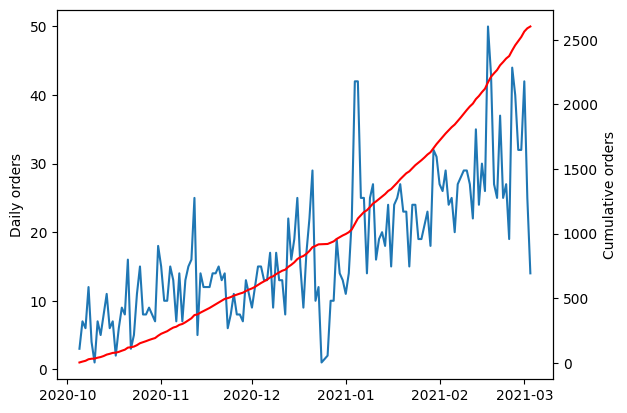

In [5]:
from matplotlib.axes import Axes

daily_orders = df_selected.groupby("order_date").order_id.nunique()
cumsum_daily_orders = daily_orders.cumsum()
fig, ax = plt.subplots()
ax: Axes
ax.plot(daily_orders, label="daily orders")
axi = ax.twinx()
axi.plot(cumsum_daily_orders, color="r", label="cumulative orders")
ax.set_ylabel("Daily orders")
axi.set_ylabel("Cumulative orders")

As previously stated in module 3, we will make a temporal split to prevent information leakeage.

In [6]:
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()

train_val_cutoff = cumsum_daily_orders[cumsum_daily_orders < 0.7].idxmax()
val_test_cutoff = cumsum_daily_orders[cumsum_daily_orders < 0.9].idxmax()
print("Train since:", cumsum_daily_orders.index.min())
print("Train until:", train_val_cutoff)
print("Validation since:", train_val_cutoff)
print("Validation until:", val_test_cutoff)
print("Test since:", val_test_cutoff)
print("Test until:", cumsum_daily_orders.index.max())

Train since: 2020-10-05
Train until: 2021-02-04
Validation since: 2021-02-04
Validation until: 2021-02-22
Test since: 2021-02-22
Test until: 2021-03-03


In [7]:
train_df = df_selected[df_selected.order_date <= train_val_cutoff]
val_df = df_selected[
    (df_selected.order_date > train_val_cutoff)
    & (df_selected.order_date <= val_test_cutoff)
]
test_df = df_selected[df_selected.order_date > val_test_cutoff]

In [8]:
def feature_label_split(
    df: pd.DataFrame, target: str
) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(columns=[target]), df[target]


X_train, y_train = feature_label_split(train_df, target)
X_val, y_val = feature_label_split(val_df, target)
X_test, y_test = feature_label_split(test_df, target)
train_cols = numerical_cols + binary_cols

# Base Model

In order to know if we are following the right path, we will start by creating a simple model that will serve as a baseline and benchmark for future models.  we will take a simple predictor as the baseline(column: `Global popularity`). Since we are dealing with a binary classification problem (purchased or not purchased), the metrics used will be: Precision-Recall curve and AUC-ROC curve. The Precision-Recall curve it's a specially good metric to use when the classes are imbalanced, as is the case here. All these metrics are based on the famous confusion matrix.

In [44]:
def calculate_metrics(
    model_name: str,
    train_proba: pd.Series,
    y_train: pd.Series,
    val_proba: pd.Series,
    y_val: pd.Series,
):
    train_roc_auc = roc_auc_score(y_train, train_proba)
    train_crossentropy = log_loss(y_train, train_proba)
    train_ap = average_precision_score(y_train, train_proba)
    val_roc_auc = roc_auc_score(y_val, val_proba)
    val_crossentropy = log_loss(y_val, val_proba)
    val_ap = average_precision_score(y_val, val_proba)

    print(
        f"{model_name}: Train AUC = {train_roc_auc:.3f}, Val AUC = {val_roc_auc:.3f}; "
        f"Train AP = {train_ap:.3f}, Val AP = {val_ap:.3f}; "
        f"Train Crossentropy = {train_crossentropy:.3f}, Val Crossentropy = {val_crossentropy:.3f}"
    )
    return train_ap, val_ap, train_crossentropy, val_crossentropy


def plot_metrics(
    model_name: str,
    y_pred: pd.Series,
    y_test: pd.Series,
    figure: Tuple[matplotlib.figure.Figure, np.array] = None,
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(17, 4))
    else:
        fig, ax = figure

    ax[0].plot(recall_, precision_, label=f"{model_name} (AUC = {pr_auc:.2f})")
    ax[0].set_xlabel("Recall")
    ax[0].set_ylabel("Precision")
    ax[0].set_title("Precision-Recall curve")
    ax[0].legend(loc="best")

    ax[1].plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC curve")
    ax[1].legend(loc="best")

Baseline model: Train AUC = 0.787, Val AUC = 0.787; Train AP = 0.060, Val AP = 0.066; Train Crossentropy = 0.070, Val Crossentropy = 0.064


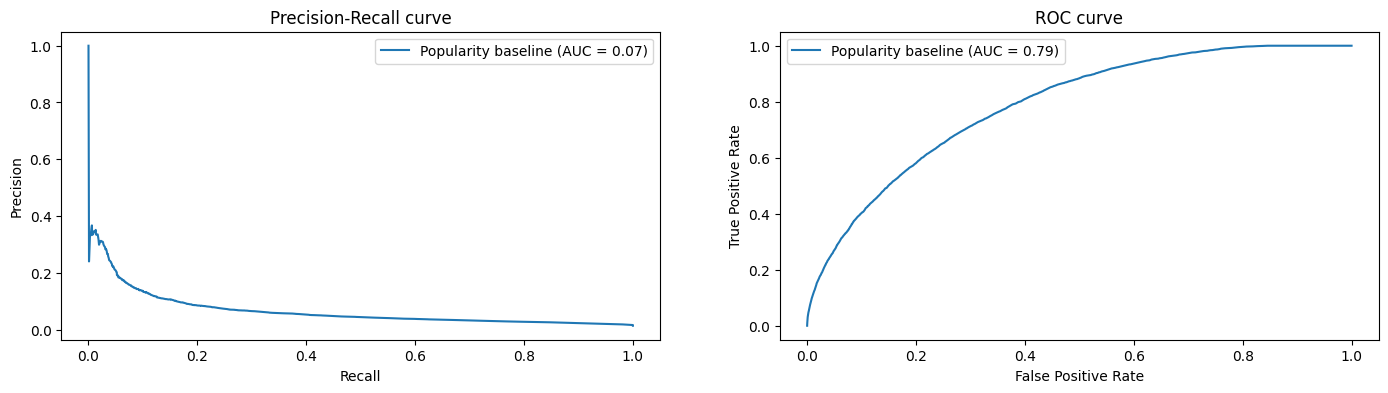

In [45]:
val_log_loss = []
val_avg_precision = []
calculate_metrics(
    "Baseline model",
    train_df["global_popularity"],
    y_train,
    val_df["global_popularity"],
    y_val,
)
plot_metrics(
    "Popularity baseline", y_pred=val_df["global_popularity"], y_test=val_df[target]
)

# Fitting models

## Random forest

RandomForestClassifier (n_estimators=5): Train AUC = 0.991, Val AUC = 0.645; Train AP = 0.770, Val AP = 0.072; Train Crossentropy = 0.025, Val Crossentropy = 0.345
RandomForestClassifier (n_estimators=25): Train AUC = 0.995, Val AUC = 0.714; Train AP = 0.852, Val AP = 0.111; Train Crossentropy = 0.021, Val Crossentropy = 0.251
RandomForestClassifier (n_estimators=50): Train AUC = 0.996, Val AUC = 0.731; Train AP = 0.859, Val AP = 0.119; Train Crossentropy = 0.021, Val Crossentropy = 0.222
RandomForestClassifier (n_estimators=100): Train AUC = 0.996, Val AUC = 0.749; Train AP = 0.863, Val AP = 0.125; Train Crossentropy = 0.021, Val Crossentropy = 0.190


Text(0.5, 1.0, 'Average precision vs n_estimators')

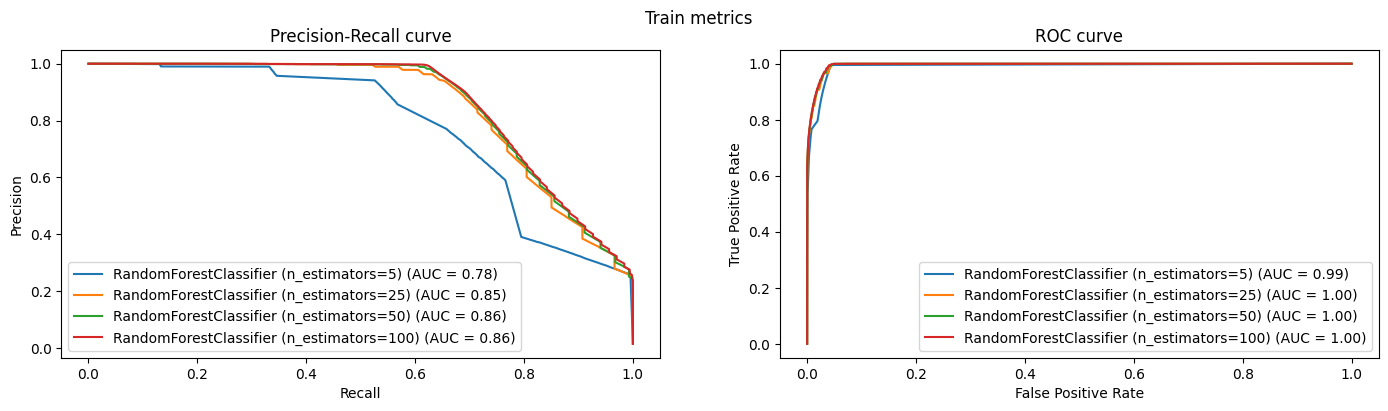

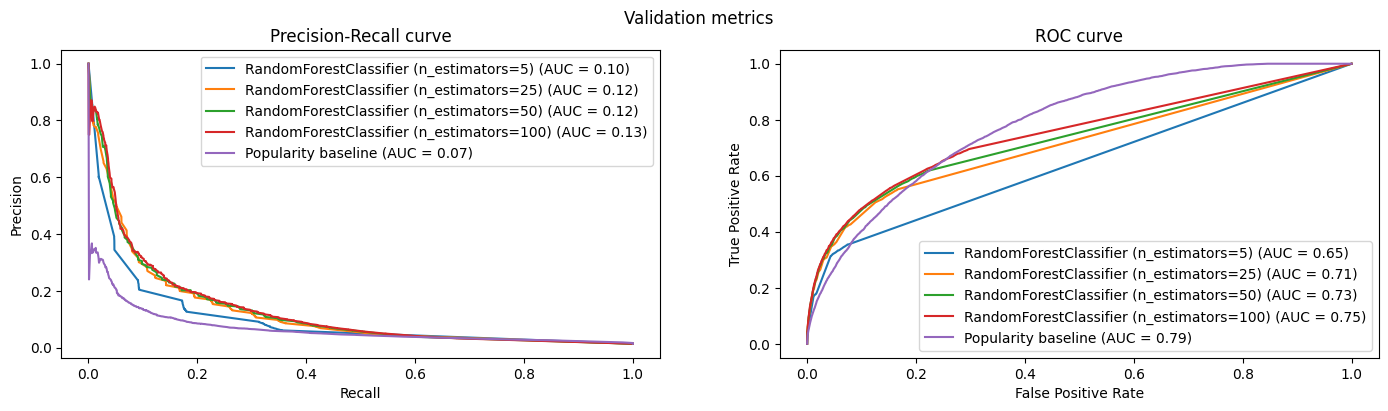

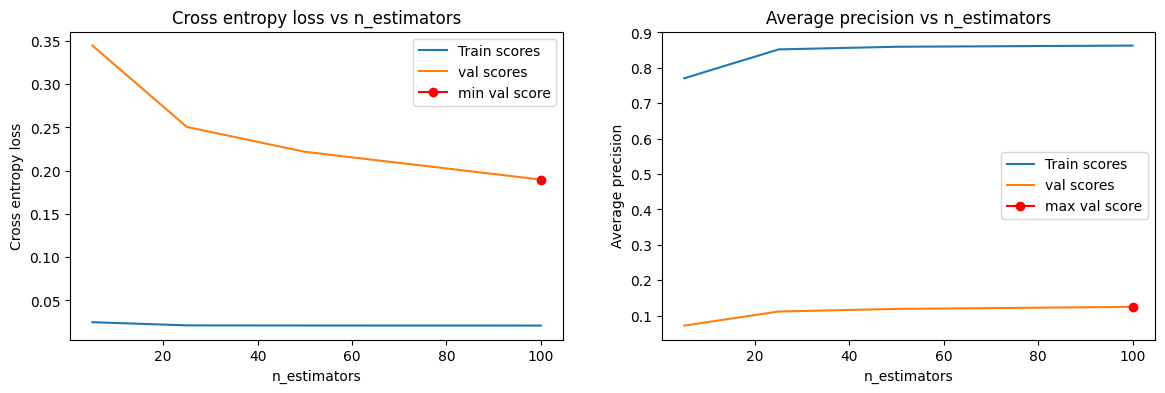

In [56]:
n_estimators = [5, 25, 50, 100]
train_log_loss = []
val_log_loss = []
train_avg_precision = []
val_avg_precision = []
fig1, ax1 = plt.subplots(1, 2, figsize=(17, 4))
fig1.suptitle("Train metrics")
fig2, ax2 = plt.subplots(1, 2, figsize=(17, 4))
fig2.suptitle("Validation metrics")

for tree_size in n_estimators:
    model = RandomForestClassifier(n_estimators=tree_size, random_state=0, n_jobs=-1)
    model.fit(X_train[train_cols], y_train)
    train_proba = model.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(
        f"RandomForestClassifier (n_estimators={tree_size})",
        train_proba,
        y_train,
        (fig1, ax1),
    )
    val_proba = model.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"RandomForestClassifier (n_estimators={tree_size})",
        val_proba,
        y_val,
        (fig2, ax2),
    )
    train_ap_, val_ap_, train_log_loss_, val_log_loss_ = calculate_metrics(
        f"RandomForestClassifier (n_estimators={tree_size})",
        train_proba,
        y_train,
        val_proba,
        y_val,
    )
    train_log_loss.append(train_log_loss_)
    val_log_loss.append(val_log_loss_)
    train_avg_precision.append(train_ap_)
    val_avg_precision.append(val_ap_)

plot_metrics(
    "Popularity baseline",
    y_pred=val_df["global_popularity"],
    y_test=val_df[target],
    figure=(fig2, ax2),
)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(n_estimators, train_log_loss, label="Train scores")
ax[0].plot(n_estimators, val_log_loss, label="val scores")
ax[0].plot(
    n_estimators[np.argmin(val_log_loss)],
    min(val_log_loss),
    marker="o",
    color="r",
    label="min val score",
)
ax[0].set_ylabel("Cross entropy loss")
ax[0].set_xlabel("n_estimators")
ax[0].legend(loc="best")
ax[0].set_title("Cross entropy loss vs n_estimators")

ax[1].plot(n_estimators, train_avg_precision, label="Train scores")
ax[1].plot(n_estimators, val_avg_precision, label="val scores")
ax[1].plot(
    n_estimators[np.argmax(val_avg_precision)],
    max(val_avg_precision),
    marker="o",
    color="r",
    label="max val score",
)
ax[1].set_ylabel("Average precision")
ax[1].set_xlabel("n_estimators")
ax[1].legend(loc="best")
ax[1].set_title("Average precision vs n_estimators")

- RF with better peformance in all metrics(roc_AUC, PR_AUC, AP and CrossEntropy) are the ones with more trees. 
Let's keep the one with the most trees and try to find the most important features.

In [47]:
rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
rf.fit(X_train[train_cols], y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

<Axes: xlabel='importance', ylabel='features'>

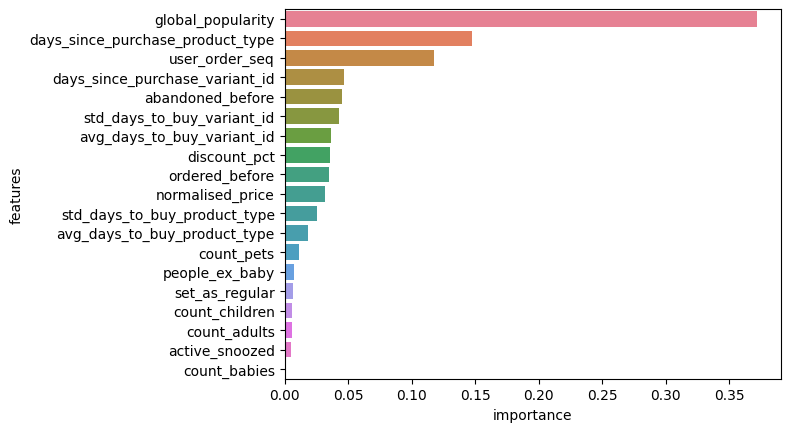

In [100]:
rf_importance_features = pd.DataFrame(
    {"features": train_cols, "importance": rf.feature_importances_}
).sort_values("importance", ascending=False)
sns.barplot(data=rf_importance_features, x="importance", y="features", hue="features")

Let's remove the worst features and see if the model improves.

In [101]:
important_cols = (
    rf_importance_features.sort_values("importance", ascending=False)
    .features[:15]
    .tolist()
)
important_cols

['global_popularity',
 'days_since_purchase_product_type',
 'user_order_seq',
 'days_since_purchase_variant_id',
 'abandoned_before',
 'std_days_to_buy_variant_id',
 'avg_days_to_buy_variant_id',
 'discount_pct',
 'ordered_before',
 'normalised_price',
 'std_days_to_buy_product_type',
 'avg_days_to_buy_product_type',
 'count_pets',
 'people_ex_baby',
 'set_as_regular']

RF (n_features=1): Train AUC = 0.808, Val AUC = 0.730; Train AP = 0.080, Val AP = 0.051; Train Crossentropy = 0.067, Val Crossentropy = 0.089
RF (n_features=2): Train AUC = 0.898, Val AUC = 0.600; Train AP = 0.296, Val AP = 0.037; Train Crossentropy = 0.055, Val Crossentropy = 0.206
RF (n_features=3): Train AUC = 0.929, Val AUC = 0.635; Train AP = 0.356, Val AP = 0.038; Train Crossentropy = 0.050, Val Crossentropy = 0.208
RF (n_features=4): Train AUC = 0.934, Val AUC = 0.699; Train AP = 0.448, Val AP = 0.085; Train Crossentropy = 0.046, Val Crossentropy = 0.174
RF (n_features=5): Train AUC = 0.939, Val AUC = 0.693; Train AP = 0.486, Val AP = 0.097; Train Crossentropy = 0.044, Val Crossentropy = 0.185
RF (n_features=6): Train AUC = 0.995, Val AUC = 0.738; Train AP = 0.827, Val AP = 0.112; Train Crossentropy = 0.023, Val Crossentropy = 0.194
RF (n_features=7): Train AUC = 0.995, Val AUC = 0.743; Train AP = 0.828, Val AP = 0.112; Train Crossentropy = 0.023, Val Crossentropy = 0.178
RF (n_

Text(0.5, 1.0, 'Average precision vs n_features')

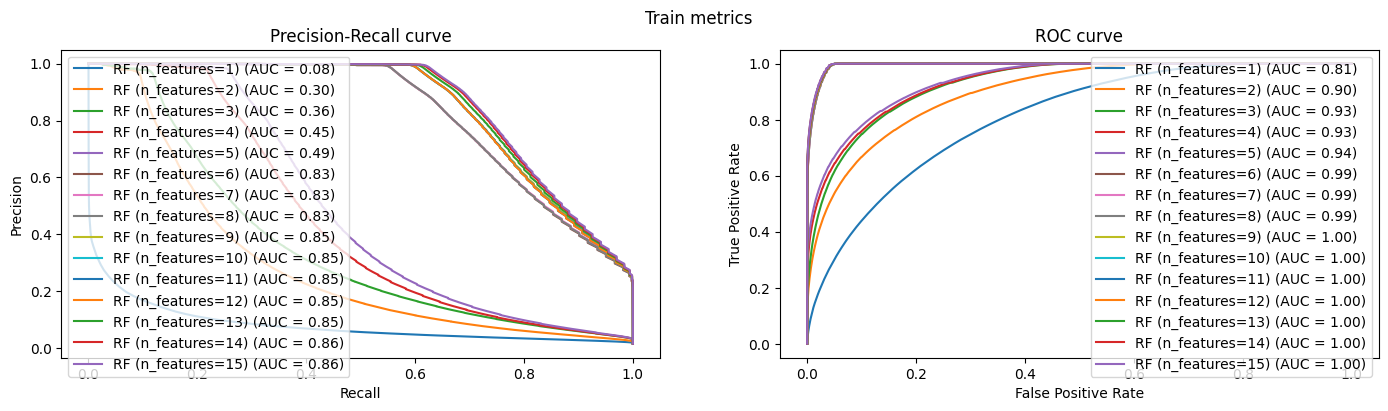

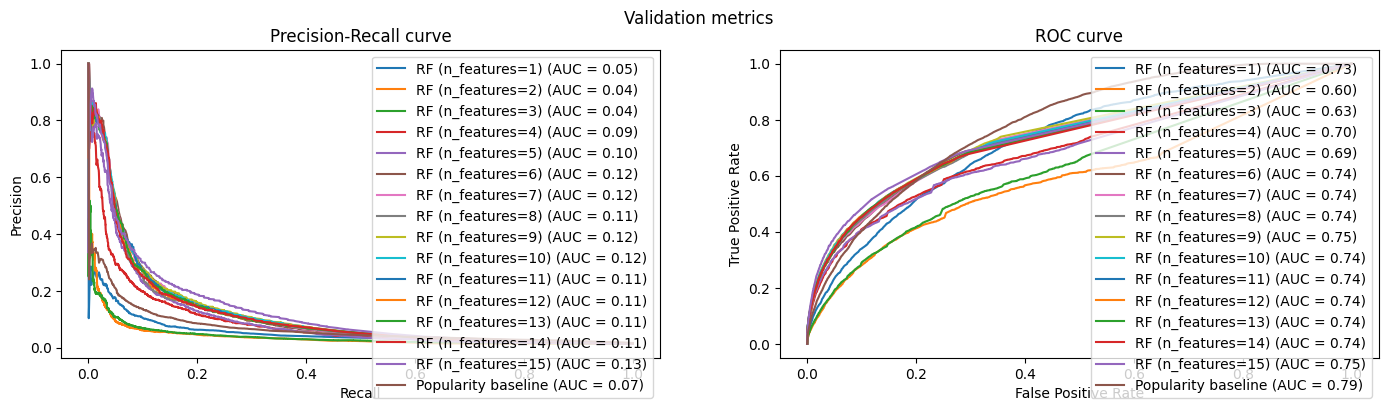

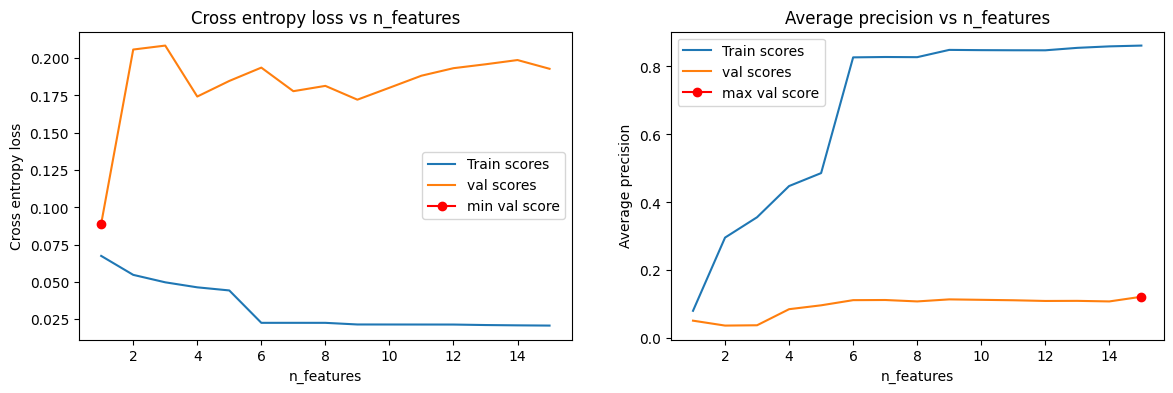

In [103]:
train_log_loss = []
val_log_loss = []
train_avg_precision = []
val_avg_precision = []

fig1, ax1 = plt.subplots(1, 2, figsize=(17, 4))
fig1.suptitle("Train metrics")
fig2, ax2 = plt.subplots(1, 2, figsize=(17, 4))
fig2.suptitle("Validation metrics")

for i in range(1, len(important_cols) + 1):
    rf.fit(X_train[important_cols[:i]], y_train)
    train_proba = rf.predict_proba(X_train[important_cols[:i]])[:, 1]
    plot_metrics(f"RF (n_features={i})", train_proba, y_train, (fig1, ax1))
    val_proba = rf.predict_proba(X_val[important_cols[:i]])[:, 1]
    plot_metrics(f"RF (n_features={i})", val_proba, y_val, (fig2, ax2))
    train_ap_, val_ap_, train_log_loss_, val_log_loss_ = calculate_metrics(
        f"RF (n_features={i})", train_proba, y_train, val_proba, y_val
    )
    train_log_loss.append(train_log_loss_)
    val_log_loss.append(val_log_loss_)
    train_avg_precision.append(train_ap_)
    val_avg_precision.append(val_ap_)

plot_metrics(
    "Popularity baseline",
    y_pred=val_df["global_popularity"],
    y_test=val_df[target],
    figure=(fig2, ax2),
)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(range(1, len(important_cols) + 1), train_log_loss, label="Train scores")
ax[0].plot(range(1, len(important_cols) + 1), val_log_loss, label="val scores")
ax[0].plot(
    range(1, len(important_cols) + 1)[np.argmin(val_log_loss)],
    min(val_log_loss),
    marker="o",
    color="r",
    label="min val score",
)
ax[0].set_ylabel("Cross entropy loss")
ax[0].set_xlabel("n_features")
ax[0].legend(loc="best")
ax[0].set_title("Cross entropy loss vs n_features")

ax[1].plot(range(1, len(important_cols) + 1), train_avg_precision, label="Train scores")
ax[1].plot(range(1, len(important_cols) + 1), val_avg_precision, label="val scores")
ax[1].plot(
    range(1, len(important_cols) + 1)[np.argmax(val_avg_precision)],
    max(val_avg_precision),
    marker="o",
    color="r",
    label="max val score",
)
ax[1].set_ylabel("Average precision")
ax[1].set_xlabel("n_features")
ax[1].legend(loc="best")
ax[1].set_title("Average precision vs n_features")

- Although, from the 8th feature onwards the improvements are minimal, it seems RF works best with all features.

## GBT

Training took 128.38 seconds
Top 5 Models based on Validation Val AP:
max_iter=100, learning_rate=0.05, max_depth=10: Train AUC = 0.852, Val AUC = 0.847; Train AP = 0.219, Val AP = 0.197; Train Crossentropy = 0.060, Val Crossentropy = 0.056
max_iter=50, learning_rate=0.05, max_depth=10: Train AUC = 0.848, Val AUC = 0.847; Train AP = 0.209, Val AP = 0.196; Train Crossentropy = 0.061, Val Crossentropy = 0.056
max_iter=50, learning_rate=0.05, max_depth=5: Train AUC = 0.843, Val AUC = 0.846; Train AP = 0.207, Val AP = 0.195; Train Crossentropy = 0.062, Val Crossentropy = 0.056
max_iter=25, learning_rate=0.05, max_depth=10: Train AUC = 0.844, Val AUC = 0.846; Train AP = 0.205, Val AP = 0.195; Train Crossentropy = 0.063, Val Crossentropy = 0.057
max_iter=100, learning_rate=0.05, max_depth=5: Train AUC = 0.846, Val AUC = 0.847; Train AP = 0.211, Val AP = 0.195; Train Crossentropy = 0.061, Val Crossentropy = 0.056


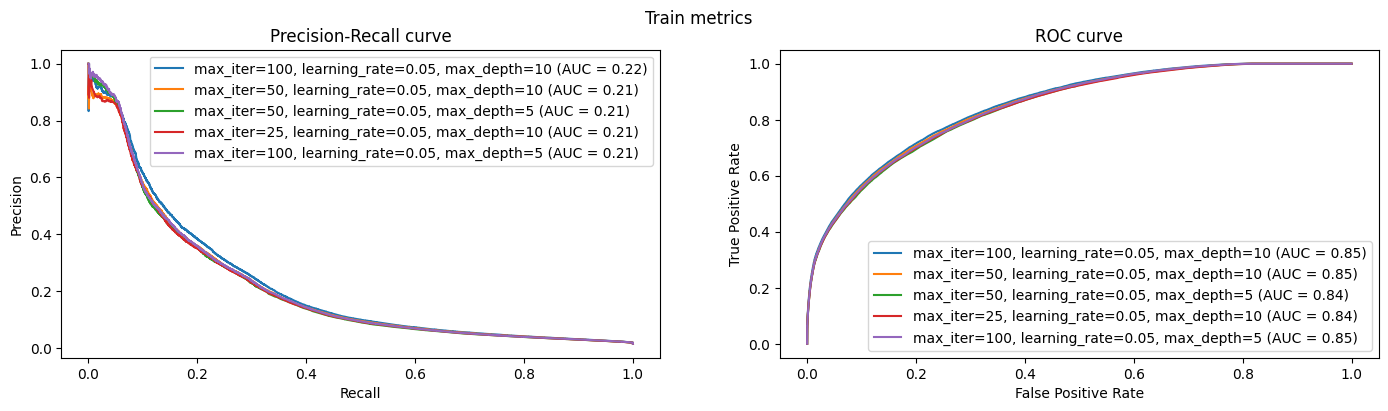

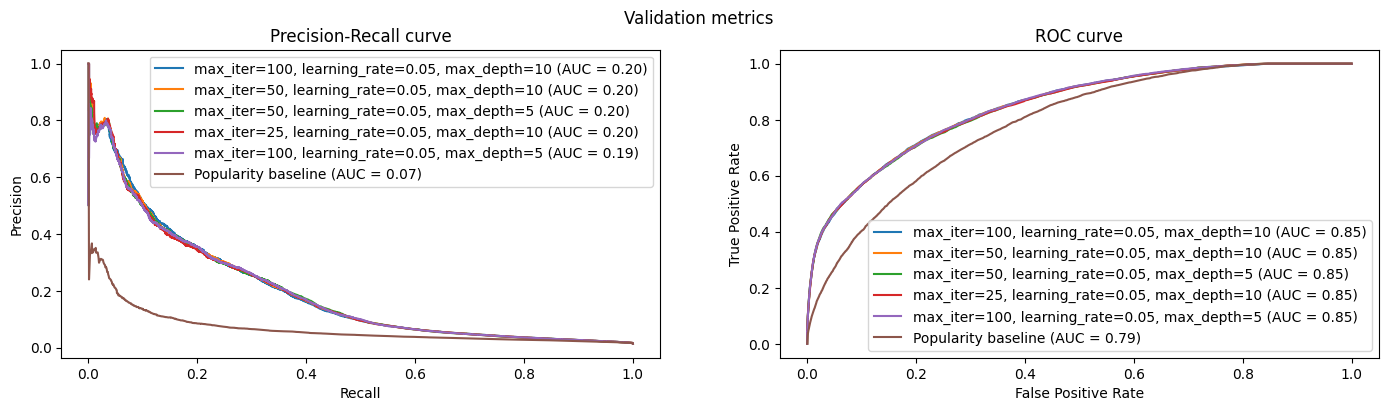

In [61]:
max_iter = [5, 10, 25, 50, 100]
lr = [0.01, 0.05, 0.1]
max_depth = [1, 5, 10]
train_log_loss = []
val_log_loss = []
train_avg_precision = []
val_avg_precision = []
model_performance = []

fig1, ax1 = plt.subplots(1, 2, figsize=(17, 4))
fig1.suptitle("Train metrics")
fig2, ax2 = plt.subplots(1, 2, figsize=(17, 4))
fig2.suptitle("Validation metrics")

time_start = time.time()
for max_iter in max_iter:
    for learning_rate in lr:
        for depth in max_depth:
            model = HistGradientBoostingClassifier(
                max_iter=max_iter,
                learning_rate=learning_rate,
                max_depth=depth,
                random_state=0,
            )
            model.fit(X_train[train_cols], y_train)
            train_proba = model.predict_proba(X_train[train_cols])[:, 1]
            val_proba = model.predict_proba(X_val[train_cols])[:, 1]
            model_performance.append(
                {
                    "model": f"max_iter={max_iter}, learning_rate={learning_rate}, max_depth={depth}",
                    "train_proba": train_proba,
                    "val_proba": val_proba,
                    "val_avg_precision": average_precision_score(y_val, val_proba),
                }
            )
time_end = time.time()
print(f"Training took {time_end - time_start:.2f} seconds")
# Sort the models based on validation AP (descending, since higher AP is better)
sorted_models = sorted(
    model_performance, key=lambda x: x["val_avg_precision"], reverse=True
)
print("Top 5 Models based on Validation Val AP:")
for model_info in sorted_models[:5]:
    calculate_metrics(
        model_info["model"],
        model_info["train_proba"],
        y_train,
        model_info["val_proba"],
        y_val,
    )
    plot_metrics(model_info["model"], model_info["train_proba"], y_train, (fig1, ax1))
    plot_metrics(model_info["model"], model_info["val_proba"], y_val, (fig2, ax2))
plot_metrics(
    "Popularity baseline",
    y_pred=val_df["global_popularity"],
    y_test=val_df[target],
    figure=(fig2, ax2),
)

- Much better performance than RF in all metrics. 
- The best model has the following hyperparameters: 100 iterations, learning rate of 0.05 and and max depth of 10. Nevertheless, the difference between the bests gbt models is insignificant.

As we did with RF, let's remove the worst features and see if the model improves.

In [63]:
best_GBT = HistGradientBoostingClassifier(
    max_iter=100, learning_rate=0.05, max_depth=10, random_state=0
)
best_GBT.fit(X_train[train_cols], y_train)

HistGradientBoostingClassifier(learning_rate=0.05, max_depth=10, random_state=0)

In [65]:
from sklearn.inspection import permutation_importance

# Histogram-based Gradient Boosting Trees doens't have a feature_importances_ attribute, so we use permutation_importance method instead.
result = permutation_importance(
    best_GBT,
    X_train[train_cols],
    y_train,
    scoring="average_precision",
    n_repeats=5,
    random_state=0,
    n_jobs=-1,
)

In [82]:
gbt_importance_features = pd.DataFrame(
    {
        "features": train_cols,
        "importances_mean": result.importances_mean,
        "importances_std": result.importances_std,
    }
).sort_values("importances_mean", ascending=False)

<ErrorbarContainer object of 3 artists>

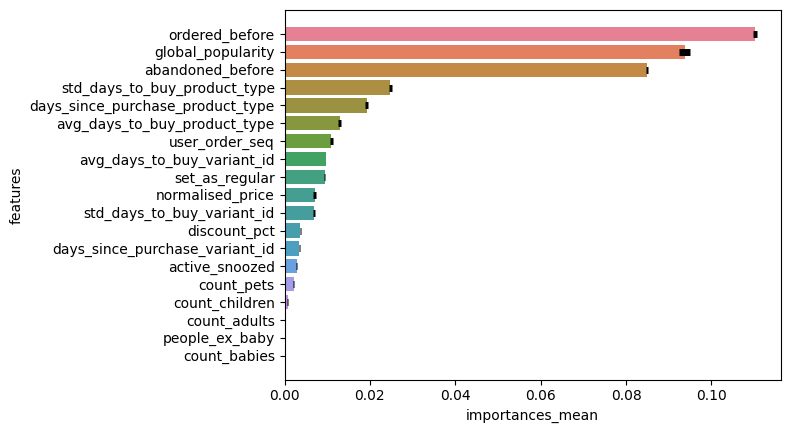

In [91]:
import seaborn as sns

sns.barplot(
    data=gbt_importance_features, x="importances_mean", y="features", hue="features"
).errorbar(
    x=gbt_importance_features.importances_mean,
    y=gbt_importance_features.features,
    xerr=gbt_importance_features.importances_std,
    fmt="none",
    linewidth=5,
    c="black",
)

In [96]:
gbt_columns = gbt_importance_features.sort_values(
    "importances_mean", ascending=False
).features[:15]
gbt_columns

15                      ordered_before
3                    global_popularity
16                    abandoned_before
14        std_days_to_buy_product_type
12    days_since_purchase_product_type
13        avg_days_to_buy_product_type
0                       user_order_seq
10          avg_days_to_buy_variant_id
18                      set_as_regular
1                     normalised_price
11          std_days_to_buy_variant_id
2                         discount_pct
9       days_since_purchase_variant_id
17                      active_snoozed
7                           count_pets
Name: features, dtype: object

In [97]:
for i in range(1, len(gbt_columns) + 1):
    best_GBT.fit(X_train[gbt_columns[:i]], y_train)
    train_proba = best_GBT.predict_proba(X_train[gbt_columns[:i]])[:, 1]
    val_proba = best_GBT.predict_proba(X_val[gbt_columns[:i]])[:, 1]
    calculate_metrics(f"GBT (top {i} features)", train_proba, y_train, val_proba, y_val)
    plot_metrics(f"GBT (top {i} features)", val_proba, y_val, (fig2, ax2))

GBT (top 1 features): Train AUC = 0.628, Val AUC = 0.648; Train AP = 0.055, Val AP = 0.066; Train Crossentropy = 0.071, Val Crossentropy = 0.064
GBT (top 2 features): Train AUC = 0.828, Val AUC = 0.832; Train AP = 0.123, Val AP = 0.144; Train Crossentropy = 0.064, Val Crossentropy = 0.058
GBT (top 3 features): Train AUC = 0.835, Val AUC = 0.835; Train AP = 0.179, Val AP = 0.159; Train Crossentropy = 0.063, Val Crossentropy = 0.057
GBT (top 4 features): Train AUC = 0.840, Val AUC = 0.835; Train AP = 0.194, Val AP = 0.176; Train Crossentropy = 0.062, Val Crossentropy = 0.057
GBT (top 5 features): Train AUC = 0.845, Val AUC = 0.838; Train AP = 0.200, Val AP = 0.177; Train Crossentropy = 0.061, Val Crossentropy = 0.057
GBT (top 6 features): Train AUC = 0.845, Val AUC = 0.838; Train AP = 0.202, Val AP = 0.176; Train Crossentropy = 0.061, Val Crossentropy = 0.057
GBT (top 7 features): Train AUC = 0.846, Val AUC = 0.840; Train AP = 0.206, Val AP = 0.181; Train Crossentropy = 0.061, Val Crosse

From the 10th feature onwards, the performance of the GBT model does not improve significantly. Therefore, we will keep the model with the 9 most important features.

## Comparison best models:

GBT: Train AUC = 0.849, Val AUC = 0.846; Train AP = 0.213, Val AP = 0.194; Train Crossentropy = 0.061, Val Crossentropy = 0.056
RF: Train AUC = 0.996, Val AUC = 0.749; Train AP = 0.863, Val AP = 0.125; Train Crossentropy = 0.021, Val Crossentropy = 0.190
LR: Train AUC = 0.833, Val AUC = 0.834; Train AP = 0.163, Val AP = 0.148; Train Crossentropy = 0.076, Val Crossentropy = 0.070
Popularity baseline: Train AUC = 0.787, Val AUC = 0.787; Train AP = 0.060, Val AP = 0.066; Train Crossentropy = 0.070, Val Crossentropy = 0.064


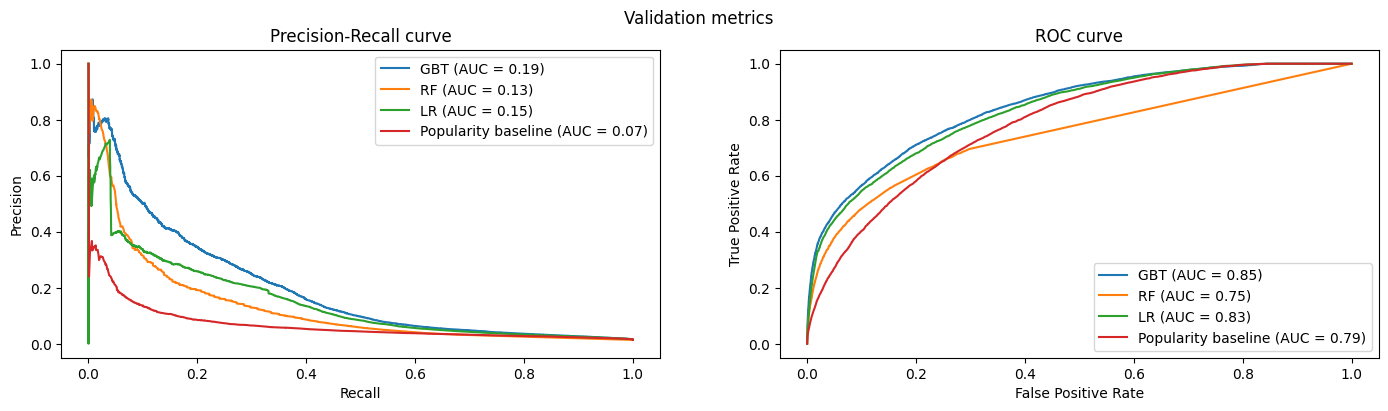

In [108]:
best_GBT = HistGradientBoostingClassifier(
    max_iter=100, learning_rate=0.05, max_depth=10, random_state=0
)
best_GBT.fit(X_train[gbt_columns[:9]], y_train)

best_RF = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
best_RF.fit(X_train[train_cols], y_train)

# best model from module 3: Logistic Regression
from sklearn.linear_model import LogisticRegression

LR_cols = ["ordered_before", "abandoned_before", "global_popularity"]
best_LR = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression(penalty="l2", C=1e-6)),
    ]
)
best_LR.fit(X_train[LR_cols], y_train)

# comparing results
fig2, ax2 = plt.subplots(1, 2, figsize=(17, 4))
fig2.suptitle("Validation metrics")

calculate_metrics(
    "GBT",
    best_GBT.predict_proba(X_train[gbt_columns[:9]])[:, 1],
    y_train,
    best_GBT.predict_proba(X_val[gbt_columns[:9]])[:, 1],
    y_val,
)
plot_metrics(
    "GBT", best_GBT.predict_proba(X_val[gbt_columns[:9]])[:, 1], y_val, (fig2, ax2)
)

calculate_metrics(
    "RF",
    best_RF.predict_proba(X_train[train_cols])[:, 1],
    y_train,
    best_RF.predict_proba(X_val[train_cols])[:, 1],
    y_val,
)
plot_metrics("RF", best_RF.predict_proba(X_val[train_cols])[:, 1], y_val, (fig2, ax2))

calculate_metrics(
    "LR",
    best_LR.predict_proba(X_train[LR_cols])[:, 1],
    y_train,
    best_LR.predict_proba(X_val[LR_cols])[:, 1],
    y_val,
)
plot_metrics("LR", best_LR.predict_proba(X_val[LR_cols])[:, 1], y_val, (fig2, ax2))

calculate_metrics(
    "Popularity baseline",
    train_df["global_popularity"],
    y_train,
    val_df["global_popularity"],
    y_val,
)
plot_metrics("Popularity baseline", val_df["global_popularity"], y_val, (fig2, ax2))

- Most of module 4 work was based upon the previous module 3 work with linear models and module 2 work with EDA focus.
- Different non-linear ML models were tested and compared: Random Forest and Gradient Boosting Trees.
- Hyperparameters were tuned without using a cross-validation approach. A time series split was used instead.
- Importance of features was also evaluated. 
- The GBT model is the best model, with a better performance in all metrics.
- The cutoff point for the GBT model will be determined according to business team requirements. 